<a href="https://colab.research.google.com/github/SamiraAsadzadeh/Neural-network-exercises/blob/main/U_NET_SEGMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **By: Samira Asadzadeh  40116341054541**

*   **Advisor:  Dr. Mr.Asadi**

*  **ISLAMIC AZAD UNIVERSITY SHIRAZ BRANCH Faculty of engineering**



## **Segmentation of pathological images**


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#  ورود ماژولها

import tensorflow.keras
from tensorflow.python.keras.metrics import Metric
import os # با سیستم عامل و دایرکتوری ها ارتباط برقرار میکند
import glob #درمسیر مشخص با فایلها ارتباط برقرار میکنیم
#import keras
import random
import numpy as np #کتابخانه بزرک دارای توابغ ریاضی سطح بالا مانند ماتریسها و آرایه ها....فراهم میکند
import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras.backend as k
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt #ترسیم تصاویر در پایتون
from skimage.transform import resize # جهت تغییر سایز تصاویر
from skimage.io import imread, imshow, imsave # برای خواندن و نمایش و ذخیره تصاویر
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


In [ ]:
#Set Image Path ست کردن مسیر تصاویر
TRAIN_IMAGE_PATH = '/content/drive/MyDrive/HomeWork deep learning/5/Segmentation/Dataset/Inputs_Train'
TRAIN_MASK_PATH = '/content/drive/MyDrive/HomeWork deep learning/5/Segmentation/Dataset/Masks_Train'
TEST_IMAGE_PATH = '/content/drive/MyDrive/HomeWork deep learning/5/Segmentation/Dataset/Inputs_Test'
TEST_MASK_PATH = '/content/drive/MyDrive/HomeWork deep learning/5/Segmentation/Dataset/Masks_Test'



In [ ]:
# ست کردن سایز و بعد تصاویر
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 64, 64, 3


In [ ]:
# دسترسی به لیست فایلهای موجود در مسیر به صورت مرتب شده
#2 برای دسترسی به لیست فولدر  1# برای دسترسی به لیست فایل
#  os  برای دسترسی به لیست فایل ها در ماژول walk یک دستور هست به نام
Train_Mask_List = sorted(next(os.walk(TRAIN_MASK_PATH))[2])
Test_Mask_List = sorted(next(os.walk(TEST_MASK_PATH))[2])

In [ ]:
len (Train_Mask_List)

56

In [ ]:
#   (patch  با اطلاعات نام هر ماسک نام تصویر مورد نظر ان را پیدا می کنیم این دو را با هم پردازش می کنیم تا (موقیت دقیق پیکسلهای داخل ماسک مشخص شوند
#تعریف تابع برای داده های اموزشی
def Data_Proprocessing_Train():

      #ایجاد تنسور خام 4 بعدی برای قرار دادن تصاویر رنگی در آن
      #(بعد تصاویر و عرض تصاویر و ارتفاع تصاویر و تعداد تصاویر) = (batch, h, w, channels)
      #ایجاد تنسور خام 3 بعدی برای قرار دادن تصاویر سیاه سفید یا همان گراندتروز یا ماسک در آن
      #(بعد تصاویر و عرض تصاویر و ارتفاع تصاویر و تعداد تصاویر) = (batch, h, w)

    Init_Image = np.zeros((len(Train_Mask_List), 768, 896, 3), dtype = np.uint8) # تنسور خام را مقدار دهی اولی می کنیم تا بعد تصاویر رنگی اصلی را در تنسور دخیره کنیم
    Init_Mask = np.zeros((len(Train_Mask_List), 768, 896), dtype = np.bool_) # تنسور خام را مقدار دهی اولی می کنیم تا بعد تصاویر ماسک اصلی را در تنسور دخیره کنیم

      # تصاویر کراپ شده و تغییر سایز داده شده درون دو متغیر زیر ریخته می شود
    Train_X = np.zeros((len(Train_Mask_List), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
    Train_Y = np.zeros((len(Train_Mask_List), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool_)

    n = 0 # جهت اندیس تصاویر تعریف کردیم
                                #آدرس دهی با کمک دستور فرمت ، این دستور رشته ها و متغیرها را به درون متن و یا جایگاه مورد نظر اضافه می کند و می چسباند
    for mask_path in glob.glob('{}/*.TIF'.format(TRAIN_MASK_PATH)):

        base = os.path.basename(mask_path) #نام فایل یا دایرکتوری که در آخر آدرس باشد را بر می گرداند، در اینجا نام فایل و پسوند یا فرمت آن برگردانده می شود
        image_ID, ext = os.path.splitext(base) #نام فایل و فرمت آن را از هم جدا می کند
        image_path = '{}/{}_ccd.tif'.format(TRAIN_IMAGE_PATH, image_ID) # متد فرمت ابتدا متغیر را که حاوی آدرس مورد نظر میباشد راجایگذاری می کند سپس به نام فایل سی سی دی و فرمت جدید اضافه می کند
        mask = imread(mask_path) # دونه دونه تصاویر ماسک خوانده میشوند
        image = imread(image_path) # دونه دونه تصاویر اصلی و رنگی با فرمت جدید خوانده میشوند

        # موقعیت دقیق نقاط یا پیکسلهای تصویر با شرط رنگ سفید داخل ماسک را پیدا می کنیم
        y_coord, x_coord = np.where(mask == 255)

        # نقاط مینیم و ماکسیمم که نشان دهنده مختصات پچ یا موقعیت پیکسل مورد نظر هستند را تعریف می کنیم یعنی مختصات مناطق سفید رنگ درون ماسک را مشخص می کنیم
        y_min = min(y_coord)
        y_max = max(y_coord)
        x_min = min(x_coord)
        x_max = max(x_coord)

        #در نهایت مختصات مناطق سفید رنگی که از تصاویر ماسک بدست آماده را روی تصاویر اصلی و همچنین روی تصاویر ماسک قرار می دهیم و تصاویر را کراپ می کنیم
        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]

         # تصاویر کراپ شده را تغییر سایز می دهیم و درون دو متغیر زیر که بالا تعریف شدند می ریزیم
        Train_X[n] = resize(cropped_image[:,:,:IMG_CHANNELS],
               (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), #اندازه shape تصویری که می خواد resize بشه
               mode = 'constant',
               anti_aliasing=True,  #. وظیفه‌اش این است که تا حد امکان سطح اشیاء را صاف و «نرم» کند.چون تصاویر و کوچک کردیم استفاده می کنیم تا مشکلی پیش نیاد
               preserve_range=True) #حفظ محدوده داده و نوع تصاوی

        #np.expand_dims یک محور جدید را وارد کنید
        #axis = -1 or 0   ایجاد محور ستون
        #axis = 1  ایجاد محور سطر
        Train_Y[n] = np.expand_dims(resize(cropped_mask, #بطور خودکار تشخیص می‌دهد که گسترش روی کدام بعد باید انجام شود برای گسترش آرایه‌ها و امکان ضرب، تقسیم و جمع عناصر مورد استفاده قرار گیرد.
               (IMG_HEIGHT, IMG_WIDTH),
               mode = 'constant',
               anti_aliasing=True,
               preserve_range=True), axis = -1) # برای اضافه کردن یک بعد به ابعاد ماسک تا تنسور بدست امده هم بعد باشه با تنسور تصاویر اصلی  one hot encoding انجام عملیات

        Init_Image[n] = image # دخیره تصاویر رنگی اصلی در تنسور جهت مقایسه
        Init_Mask[n] = mask # دخیره تصاویر ماسک اصلی در تنسور جهت مقایسه

        n+=1 #  تصاویر را یکی یکی با اندیس تصاویر جلو میبرد

    return Train_X, Train_Y, Init_Image, Init_Mask

Train_Inputs, Train_Masks, Init_Image, Init_Mask = Data_Proprocessing_Train() # فراخوانی تابع

#تعریف تابع برای داده های تست
def Data_Proprocessing_Test():


    Test_X = np.zeros((len(Test_Mask_List), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
    Test_Y = np.zeros((len(Test_Mask_List), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool_)

    n = 0

    for mask_path in glob.glob('{}/*.TIF'.format(TEST_MASK_PATH)):

        base = os.path.basename(mask_path)
        image_ID, ext = os.path.splitext(base)
        image_path = '{}/{}_ccd.tif'.format(TEST_IMAGE_PATH, image_ID)
        mask = imread(mask_path)
        image = imread(image_path)

        y_coord, x_coord = np.where(mask == 255)

        y_min = min(y_coord)
        y_max = max(y_coord)
        x_min = min(x_coord)
        x_max = max(x_coord)

        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]

        Test_X[n] = resize(cropped_image[:,:,:IMG_CHANNELS],
               (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
               mode = 'constant',
               anti_aliasing=True,
               preserve_range=True)

        Test_Y[n] = np.expand_dims(resize(cropped_mask,
               (IMG_HEIGHT, IMG_WIDTH),
               mode = 'constant',
               anti_aliasing=True,
               preserve_range=True), axis = -1)


        n+=1

    return Test_X, Test_Y

Test_Inputs, Test_Masks = Data_Proprocessing_Test()



Original_Image


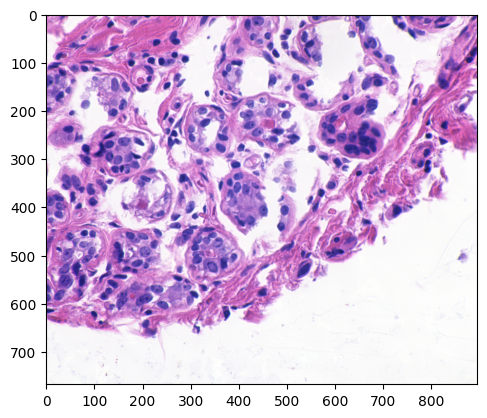

Original_Mask


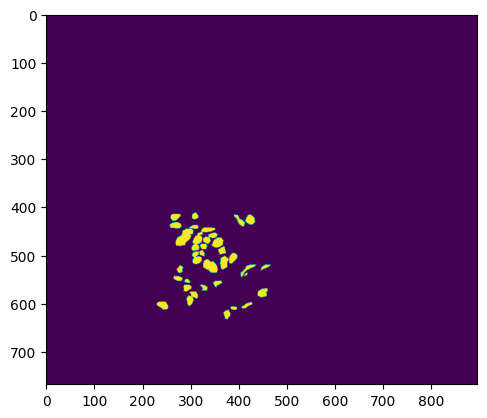

Region_of_Interest_Image


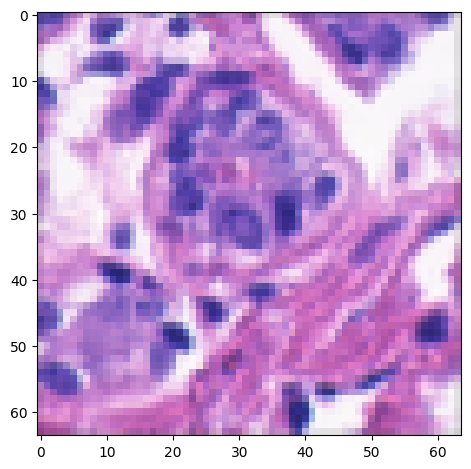

Region_of_Interest_Mask


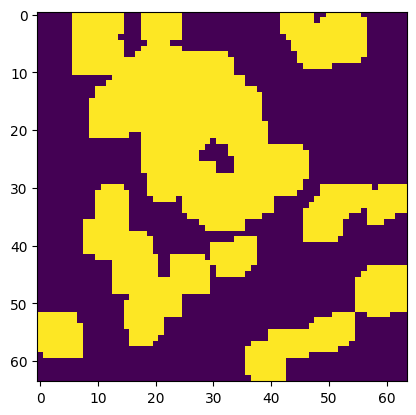

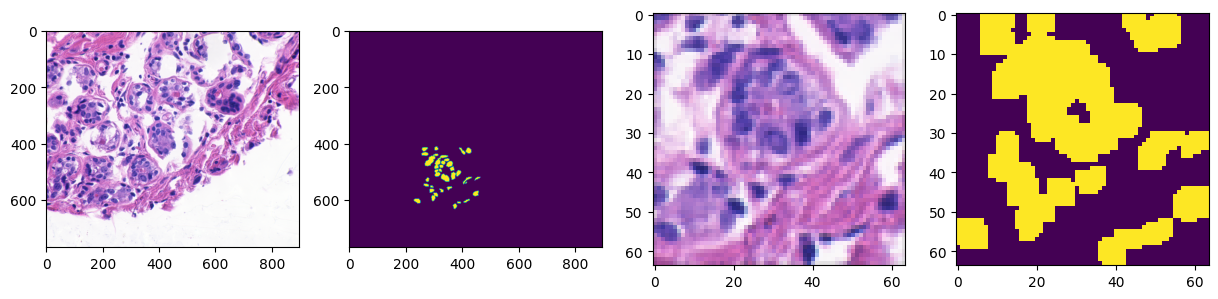

In [ ]:
 #نمایش نتایج در مرحله پیش پردازش تصاویر
print('Original_Image')
plt.imshow(Init_Image[0])
plt.show()

print('Original_Mask')
plt.imshow(Init_Mask[0])
plt.show()

print('Region_of_Interest_Image')
imshow(Train_Inputs[0])
plt.show()

print('Region_of_Interest_Mask')
plt.imshow(np.squeeze(Train_Masks[0])) #Remove axes of length one from Train_Masks. because have  one hot encoding
plt.show()
# ایجاد پلات 1در4 برای نمایش تصاویر
rows = 1
columns = 4
Figure = plt.figure(figsize=(15,15))
Image_List = [Init_Image[0], Init_Mask[0], Train_Inputs[0], Train_Masks[0]]

for i in range(1, rows*columns + 1): # از 1 تا 5

  Image = Image_List[i-1]
  Sub_Plot_Image = Figure.add_subplot(rows, columns, i)
  Sub_Plot_Image.imshow(np.squeeze(Image))
plt.show()


In [ ]:
# پیاده سازی مدل U_NET برای تقسیم بندی معنایی

def U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):

    inputs = Input(input_size)
    n = Lambda(lambda x:x/255)(inputs)


    c1 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(n)  # وزن کرنل را به صورت تصادفی توزیع نرمال با واریانس صفر و انحراف معیار پنج صدم تعیین میکند
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)


    c2 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)


    c3 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)


    c4 = Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)


    c5 = Conv2D(1024, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c5)



    u6 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c6)


    u7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c7)

    u8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c8)


    u9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c9)

    outputs = Conv2D(1,(1,1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    mIOU = tf.keras.metrics.MeanIoU(num_classes=2)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=[mIOU]) #  . نسبت ضرب مقدار پیش بینی شده و مقدار واقعی را به جمعشان محاسبه میکند. میزان همپوشانی را مشخص میکند
    model.summary()
    return model

model = U_Net_Segmentation()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 lambda (Lambda)             (None, 64, 64, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 64, 64, 64)           0         ['conv2d[0][0]']              
                                                                                              

In [ ]:
#در هر ایپاک تصویر سگمنت شده را نشان میدهد
#و مقدار loss , iou نشان میدهد
class loss_history(tf.keras.callbacks.Callback): #

    def __init__ (self, x=4): #برای دسترسی به متدها و متغیرهای یک آبجکت ایجاد شده در کلاس باید از متغیر self استفاده کنید.
        self.x = x

    def on_epoch_begin(self, epoch, logs={}): #ارث بری میکنیم از کلاس کال بک برای اینکه در هر ایپاک روند سگمنت را ببینیم

        plt.imshow(Train_Inputs[self.x])
        plt.show()

        plt.imshow(Train_Masks[self.x])
        plt.show()

        preds_train = self.model.predict(np.expand_dims(Train_Inputs[self.x], axis = 0))
        plt.imshow(np.squeeze(preds_train[0]))
        plt.show()


earlystopper = EarlyStopping(patience=7, verbose=1) # اگر در هفت گام بهبودی در آموزش انجام نشد روند آموزش متوقف شود


In [ ]:
#در هر ایپاک تصویر سگمنت شده را نشان میدهد
#و مقدار loss , iou نشان میدهد

class loss_history(tf.keras.callbacks.Callback):

    def __init__ (self, x=4):
        self.x = x

    def on_epoch_begin(self, epoch, logs={}):

        plt.imshow(Train_Inputs[self.x])
        plt.show()

        plt.imshow(np.squeeze(Train_Masks[self.x]))
        plt.show()

        preds_train = self.model.predict(np.expand_dims(Train_Inputs[self.x], axis = 0))
        plt.imshow(np.squeeze(preds_train[0]))
        plt.show()

earlystopper = EarlyStopping(patience=7, verbose=1) # اگر در هفت گام بهبودی در آموزش انجام نشد روند آموزش متوقف شود


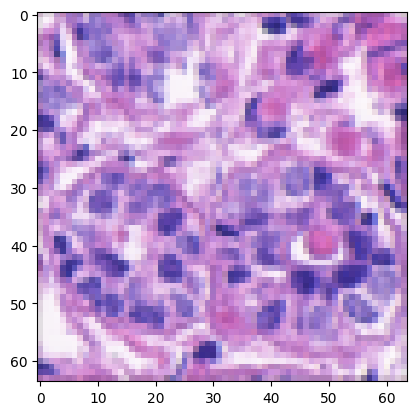

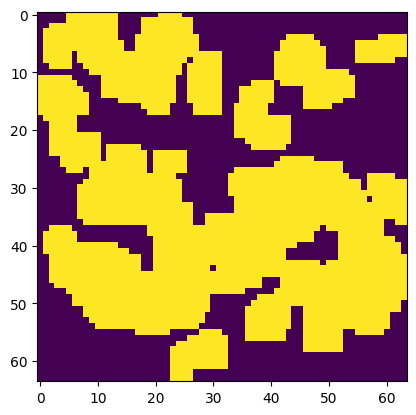

1/1 [==============================] - 0s 289ms/step


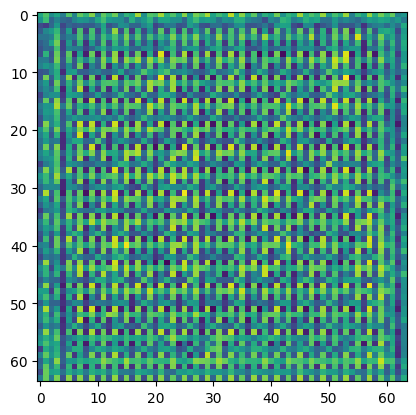

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 1.0895 - mean_io_u_2: 0.2598
Epoch 1: val_loss improved from inf to 0.87539, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 14s 267ms/step - loss: 1.0895 - mean_io_u_2: 0.2598 - val_loss: 0.8754 - val_mean_io_u_2: 0.2227


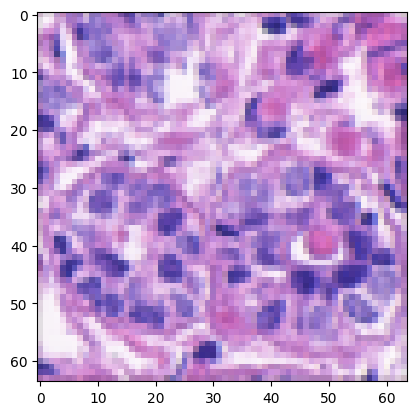

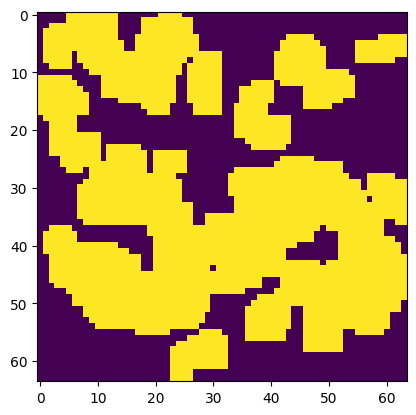

1/1 [==============================] - 0s 40ms/step


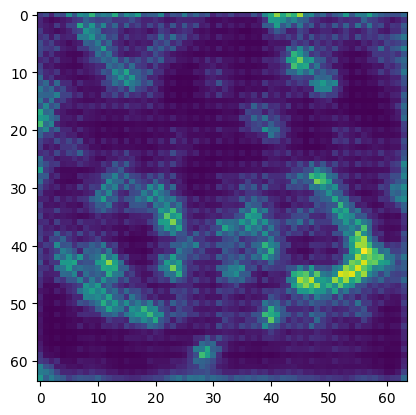

Epoch 2/100
24/25 [===========================>..] - ETA: 0s - loss: 0.5319 - mean_io_u_2: 0.2446
Epoch 2: val_loss improved from 0.87539 to 0.42054, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 7s 306ms/step - loss: 0.5318 - mean_io_u_2: 0.2436 - val_loss: 0.4205 - val_mean_io_u_2: 0.2227


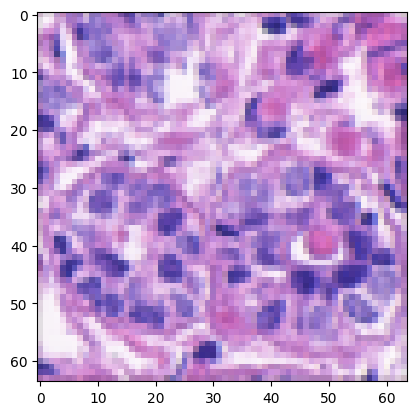

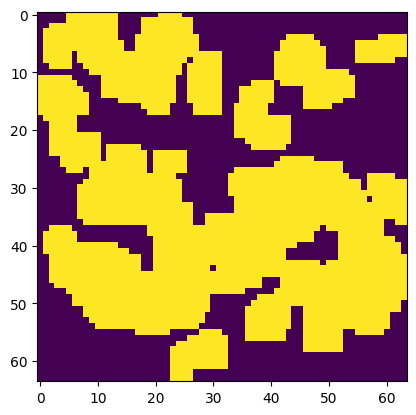

1/1 [==============================] - 0s 21ms/step


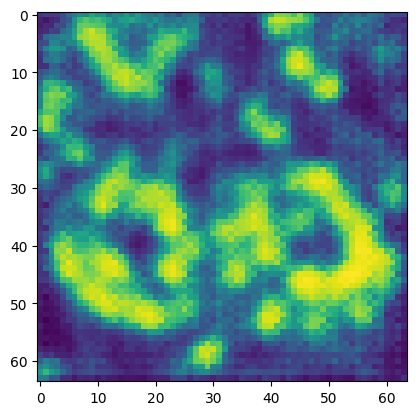

Epoch 3/100
24/25 [===========================>..] - ETA: 0s - loss: 0.4624 - mean_io_u_2: 0.2437
Epoch 3: val_loss improved from 0.42054 to 0.41770, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 7s 295ms/step - loss: 0.4604 - mean_io_u_2: 0.2436 - val_loss: 0.4177 - val_mean_io_u_2: 0.2227


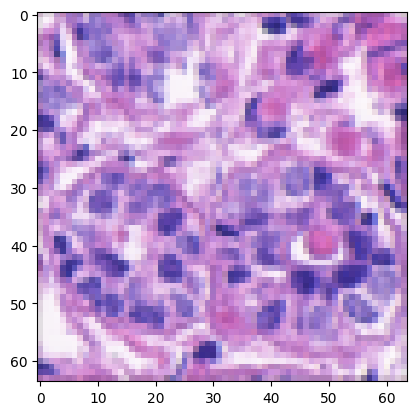

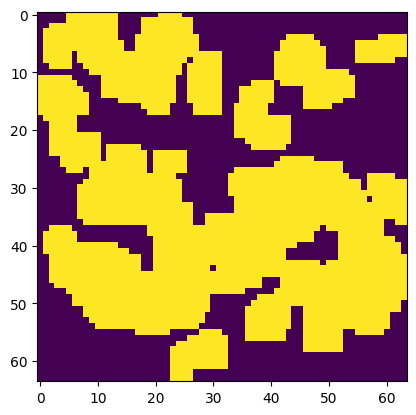

1/1 [==============================] - 0s 30ms/step


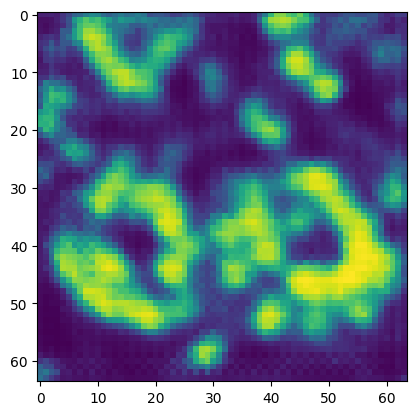

Epoch 4/100
24/25 [===========================>..] - ETA: 0s - loss: 0.4651 - mean_io_u_2: 0.2410
Epoch 4: val_loss did not improve from 0.41770
25/25 [==============================] - 1s 46ms/step - loss: 0.4676 - mean_io_u_2: 0.2436 - val_loss: 0.4614 - val_mean_io_u_2: 0.2227


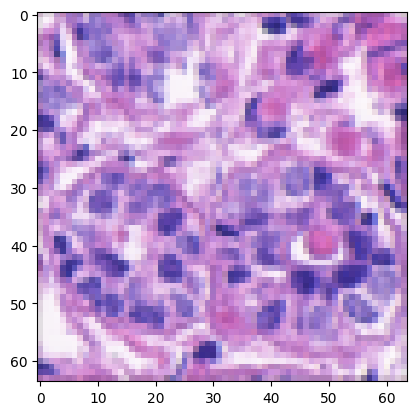

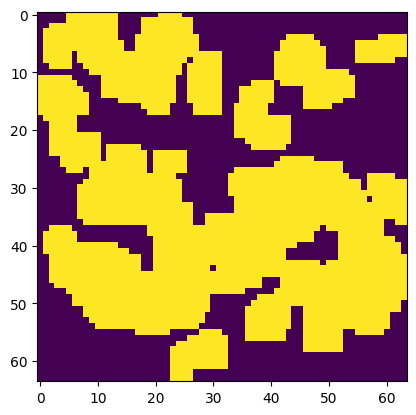

1/1 [==============================] - 0s 34ms/step


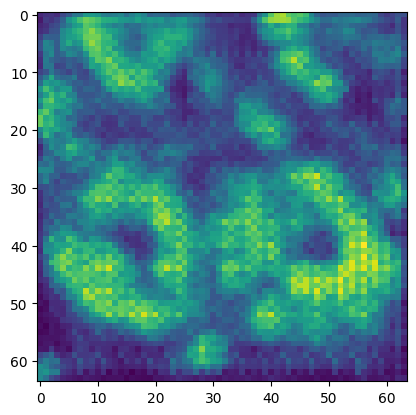

Epoch 5/100
25/25 [==============================] - ETA: 0s - loss: 0.4828 - mean_io_u_2: 0.2436
Epoch 5: val_loss did not improve from 0.41770
25/25 [==============================] - 1s 45ms/step - loss: 0.4828 - mean_io_u_2: 0.2436 - val_loss: 0.4642 - val_mean_io_u_2: 0.2227


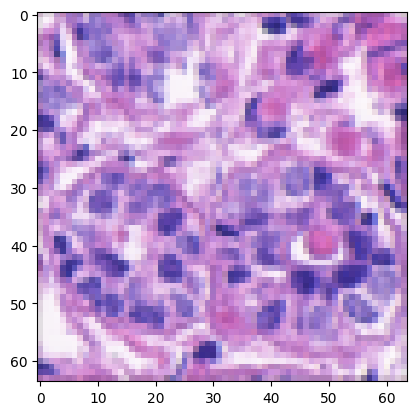

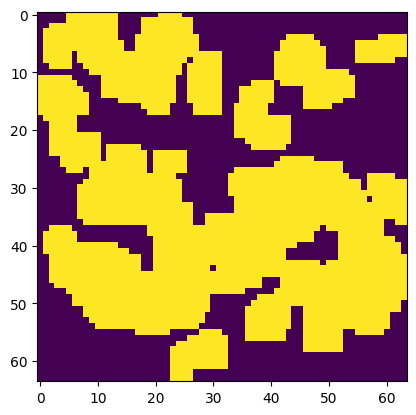

1/1 [==============================] - 0s 32ms/step


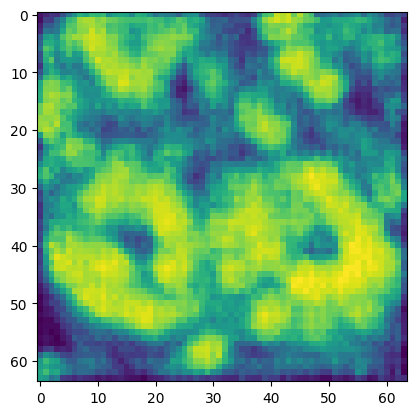

Epoch 6/100
25/25 [==============================] - ETA: 0s - loss: 0.4276 - mean_io_u_2: 0.2436
Epoch 6: val_loss improved from 0.41770 to 0.38432, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 6s 246ms/step - loss: 0.4276 - mean_io_u_2: 0.2436 - val_loss: 0.3843 - val_mean_io_u_2: 0.2227


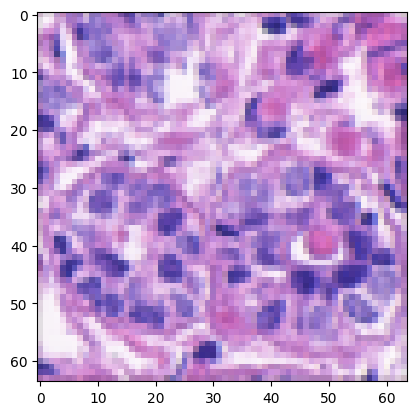

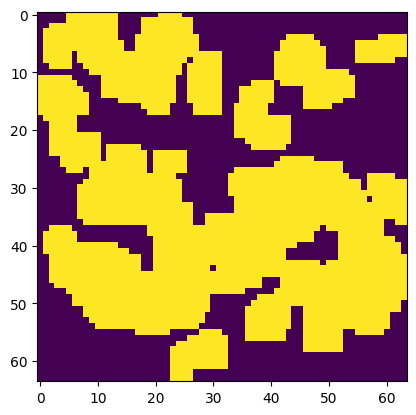

1/1 [==============================] - 0s 23ms/step


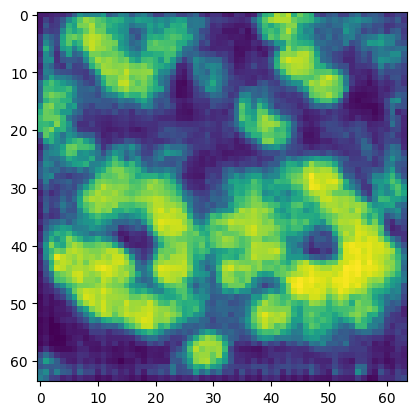

Epoch 7/100
25/25 [==============================] - ETA: 0s - loss: 0.4502 - mean_io_u_2: 0.2436
Epoch 7: val_loss did not improve from 0.38432
25/25 [==============================] - 1s 46ms/step - loss: 0.4502 - mean_io_u_2: 0.2436 - val_loss: 0.3985 - val_mean_io_u_2: 0.2227


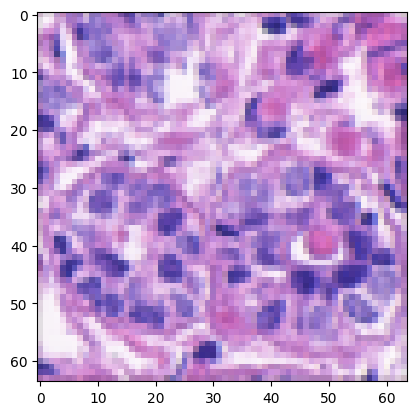

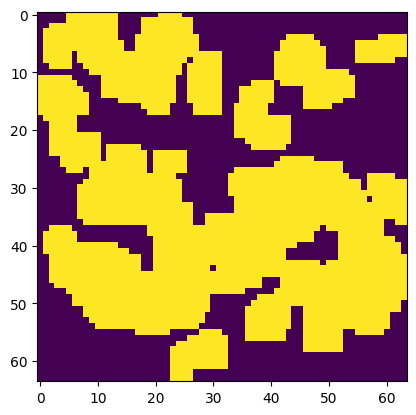

1/1 [==============================] - 0s 20ms/step


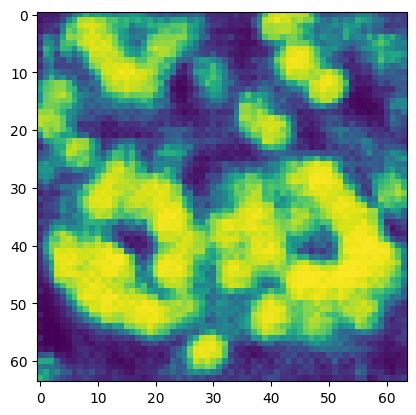

Epoch 8/100
25/25 [==============================] - ETA: 0s - loss: 0.4116 - mean_io_u_2: 0.2436
Epoch 8: val_loss did not improve from 0.38432
25/25 [==============================] - 1s 41ms/step - loss: 0.4116 - mean_io_u_2: 0.2436 - val_loss: 0.3997 - val_mean_io_u_2: 0.2227


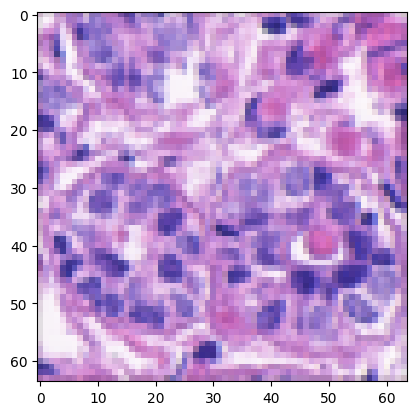

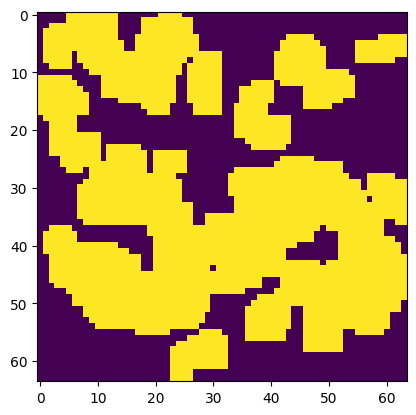

1/1 [==============================] - 0s 21ms/step


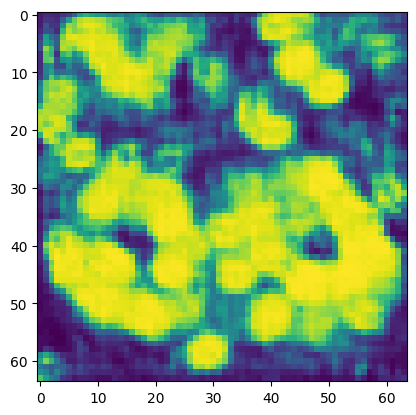

Epoch 9/100
25/25 [==============================] - ETA: 0s - loss: 0.4422 - mean_io_u_2: 0.2436
Epoch 9: val_loss improved from 0.38432 to 0.36182, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 8s 328ms/step - loss: 0.4422 - mean_io_u_2: 0.2436 - val_loss: 0.3618 - val_mean_io_u_2: 0.2227


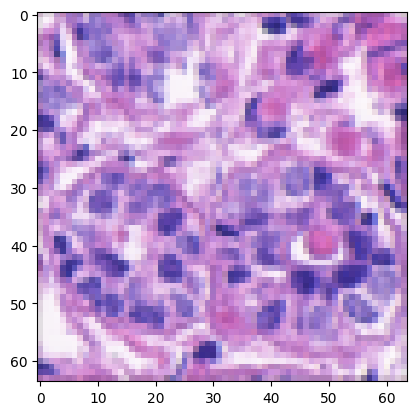

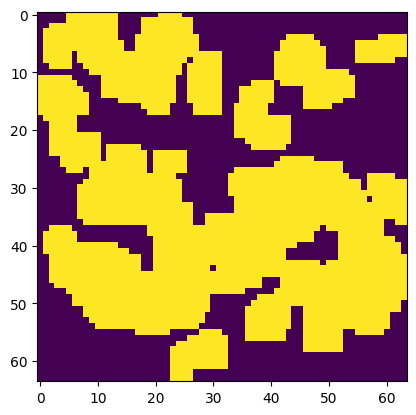

1/1 [==============================] - 0s 26ms/step


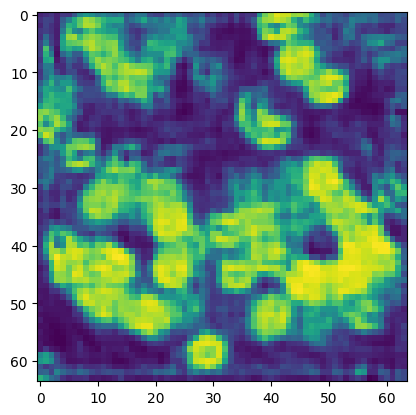

Epoch 10/100
25/25 [==============================] - ETA: 0s - loss: 0.3987 - mean_io_u_2: 0.2436
Epoch 10: val_loss improved from 0.36182 to 0.36123, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 6s 263ms/step - loss: 0.3987 - mean_io_u_2: 0.2436 - val_loss: 0.3612 - val_mean_io_u_2: 0.2227


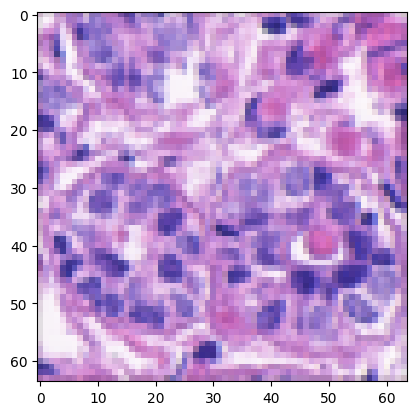

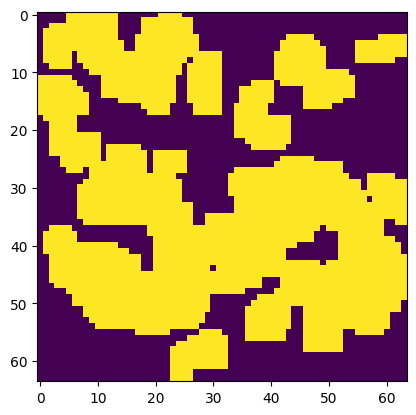

1/1 [==============================] - 0s 31ms/step


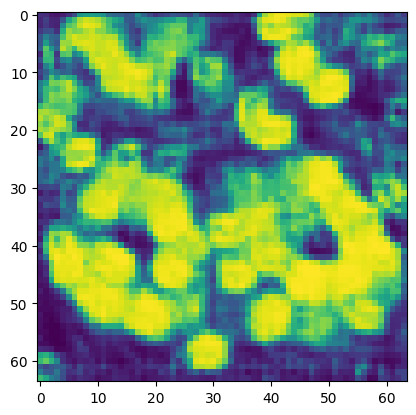

Epoch 11/100
25/25 [==============================] - ETA: 0s - loss: 0.3889 - mean_io_u_2: 0.2436
Epoch 11: val_loss improved from 0.36123 to 0.33875, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 7s 280ms/step - loss: 0.3889 - mean_io_u_2: 0.2436 - val_loss: 0.3387 - val_mean_io_u_2: 0.2227


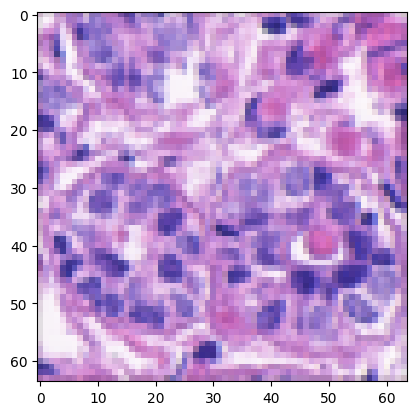

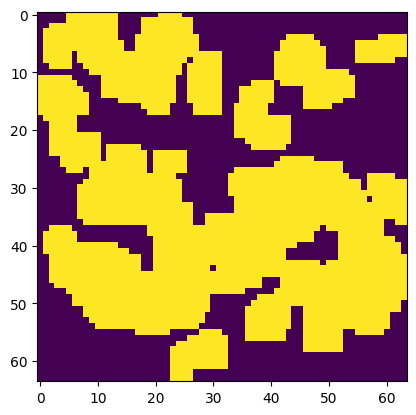

1/1 [==============================] - 0s 20ms/step


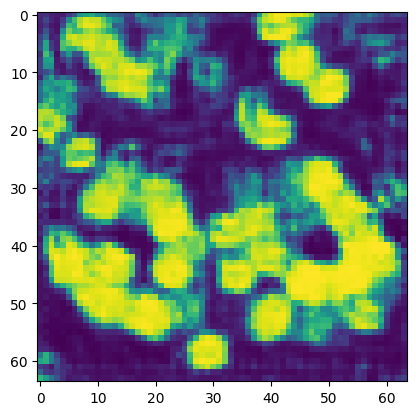

Epoch 12/100
24/25 [===========================>..] - ETA: 0s - loss: 0.3610 - mean_io_u_2: 0.2416
Epoch 12: val_loss did not improve from 0.33875
25/25 [==============================] - 1s 45ms/step - loss: 0.3572 - mean_io_u_2: 0.2436 - val_loss: 0.3645 - val_mean_io_u_2: 0.2227


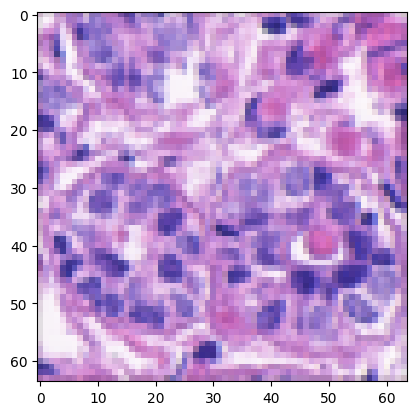

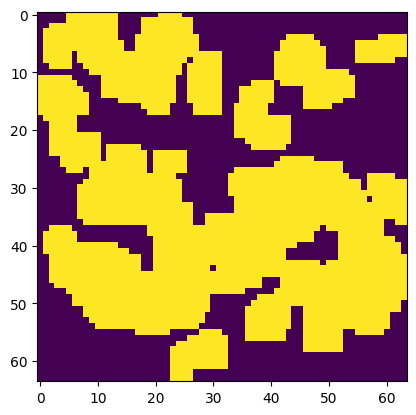

1/1 [==============================] - 0s 20ms/step


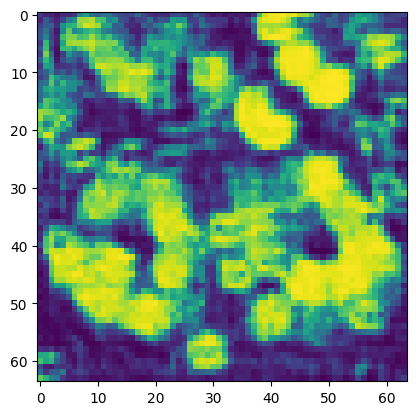

Epoch 13/100
25/25 [==============================] - ETA: 0s - loss: 0.3666 - mean_io_u_2: 0.2436
Epoch 13: val_loss improved from 0.33875 to 0.32529, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 8s 316ms/step - loss: 0.3666 - mean_io_u_2: 0.2436 - val_loss: 0.3253 - val_mean_io_u_2: 0.2227


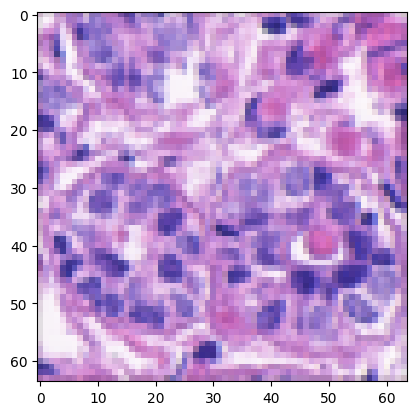

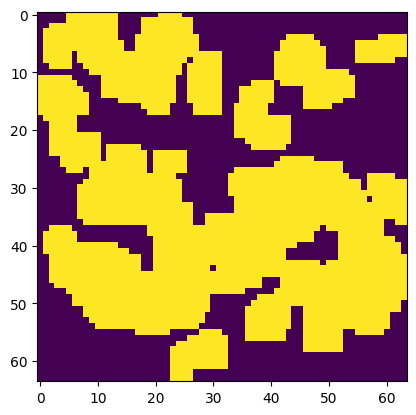

1/1 [==============================] - 0s 29ms/step


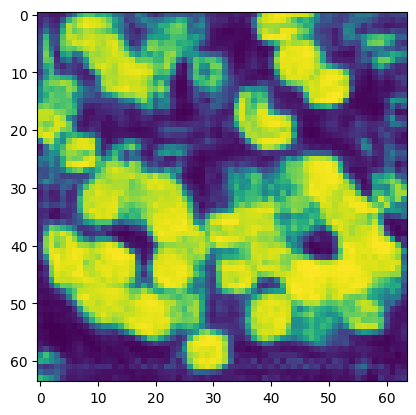

Epoch 14/100
24/25 [===========================>..] - ETA: 0s - loss: 0.3839 - mean_io_u_2: 0.2427
Epoch 14: val_loss did not improve from 0.32529
25/25 [==============================] - 1s 45ms/step - loss: 0.3849 - mean_io_u_2: 0.2436 - val_loss: 0.3842 - val_mean_io_u_2: 0.2227


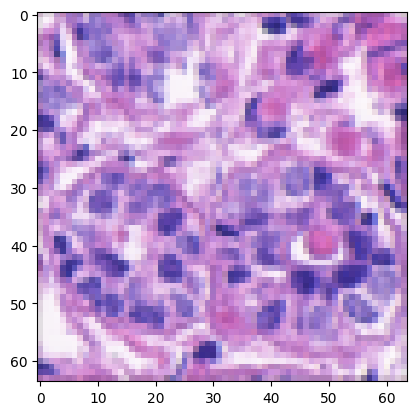

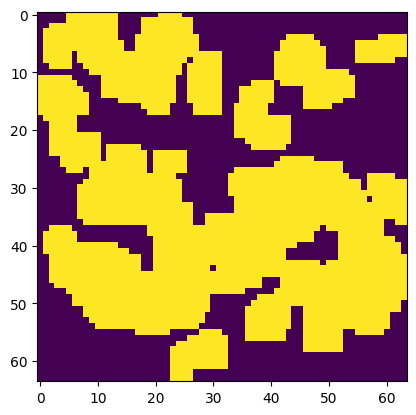

1/1 [==============================] - 0s 22ms/step


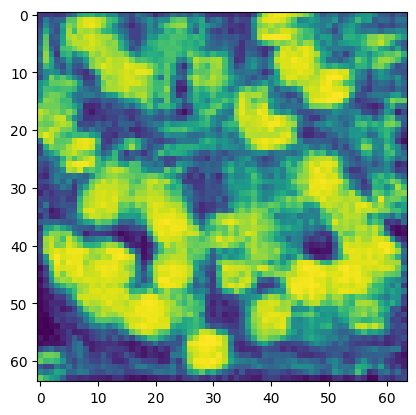

Epoch 15/100
25/25 [==============================] - ETA: 0s - loss: 0.3618 - mean_io_u_2: 0.2436
Epoch 15: val_loss improved from 0.32529 to 0.32081, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 6s 243ms/step - loss: 0.3618 - mean_io_u_2: 0.2436 - val_loss: 0.3208 - val_mean_io_u_2: 0.2227


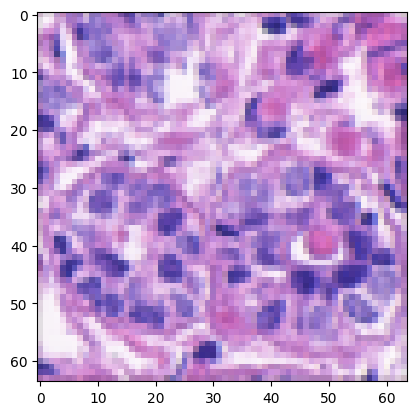

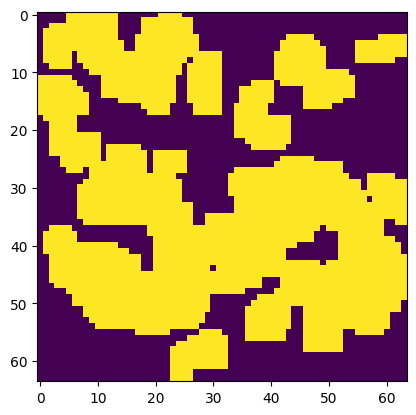

1/1 [==============================] - 0s 22ms/step


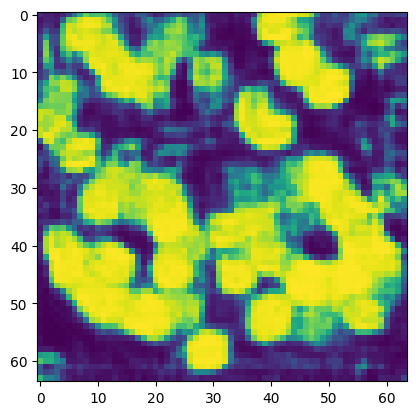

Epoch 16/100
25/25 [==============================] - ETA: 0s - loss: 0.3465 - mean_io_u_2: 0.2436
Epoch 16: val_loss did not improve from 0.32081
25/25 [==============================] - 1s 44ms/step - loss: 0.3465 - mean_io_u_2: 0.2436 - val_loss: 0.3385 - val_mean_io_u_2: 0.2227


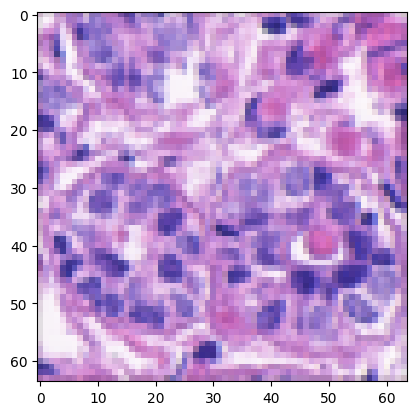

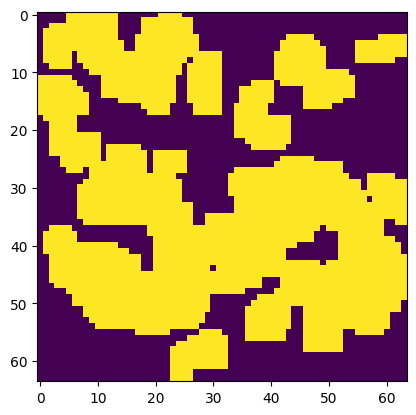

1/1 [==============================] - 0s 21ms/step


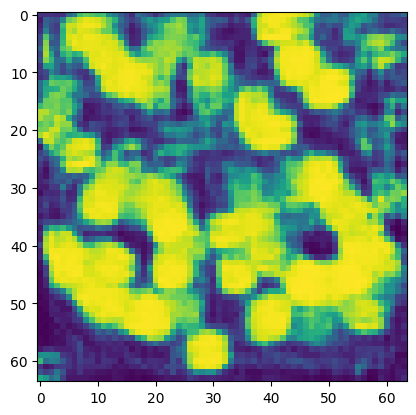

Epoch 17/100
25/25 [==============================] - ETA: 0s - loss: 0.3407 - mean_io_u_2: 0.2436
Epoch 17: val_loss improved from 0.32081 to 0.29674, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 7s 294ms/step - loss: 0.3407 - mean_io_u_2: 0.2436 - val_loss: 0.2967 - val_mean_io_u_2: 0.2227


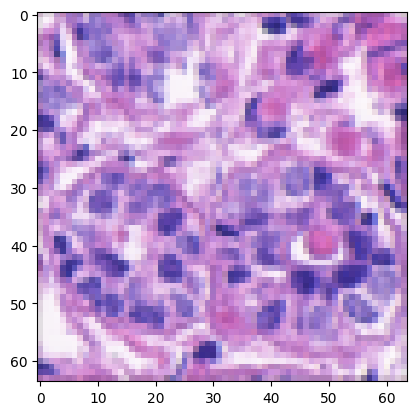

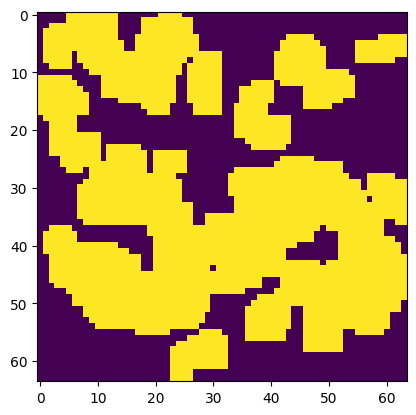

1/1 [==============================] - 0s 22ms/step


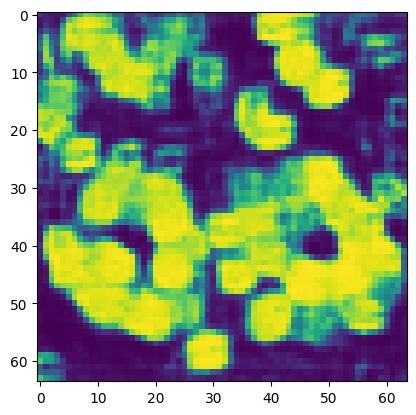

Epoch 18/100
25/25 [==============================] - ETA: 0s - loss: 0.3296 - mean_io_u_2: 0.2436
Epoch 18: val_loss did not improve from 0.29674
25/25 [==============================] - 1s 44ms/step - loss: 0.3296 - mean_io_u_2: 0.2436 - val_loss: 0.4419 - val_mean_io_u_2: 0.2227


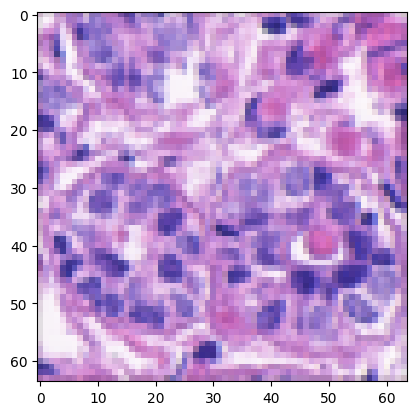

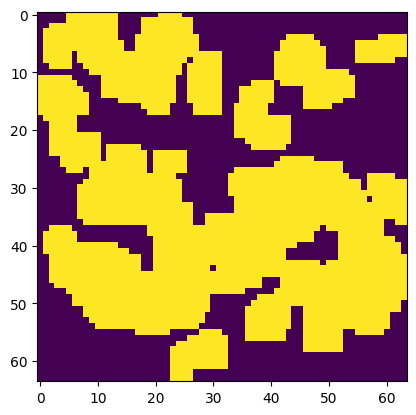

1/1 [==============================] - 0s 20ms/step


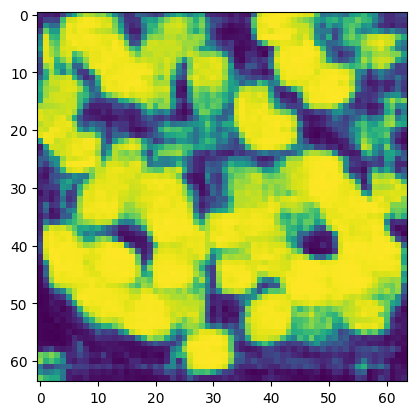

Epoch 19/100
25/25 [==============================] - ETA: 0s - loss: 0.3328 - mean_io_u_2: 0.2436
Epoch 19: val_loss did not improve from 0.29674
25/25 [==============================] - 1s 42ms/step - loss: 0.3328 - mean_io_u_2: 0.2436 - val_loss: 0.2987 - val_mean_io_u_2: 0.2227


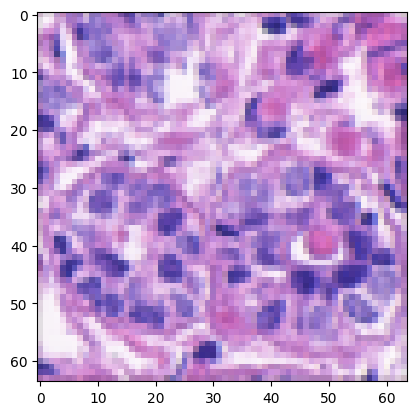

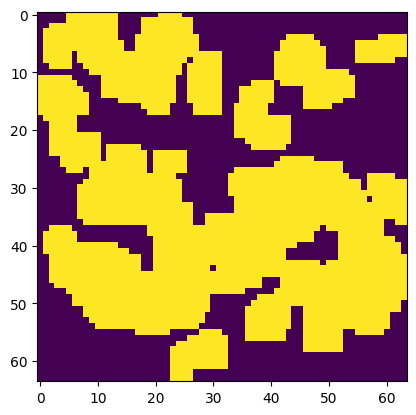

1/1 [==============================] - 0s 22ms/step


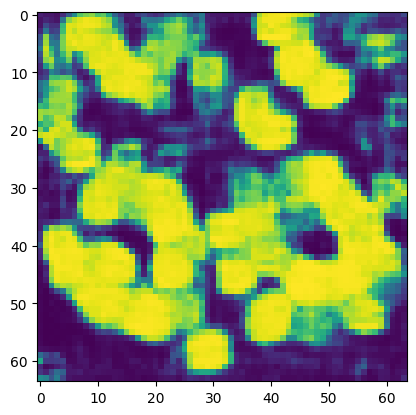

Epoch 20/100
25/25 [==============================] - ETA: 0s - loss: 0.3266 - mean_io_u_2: 0.2436
Epoch 20: val_loss did not improve from 0.29674
25/25 [==============================] - 1s 43ms/step - loss: 0.3266 - mean_io_u_2: 0.2436 - val_loss: 0.3244 - val_mean_io_u_2: 0.2227


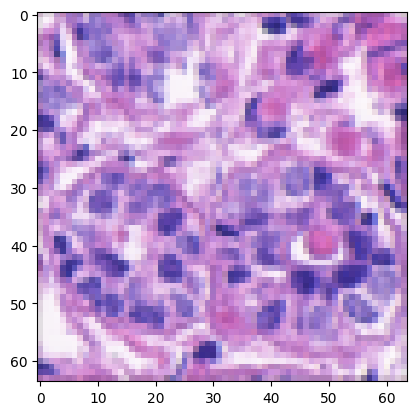

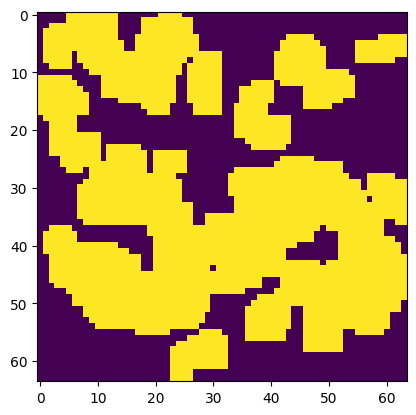

1/1 [==============================] - 0s 23ms/step


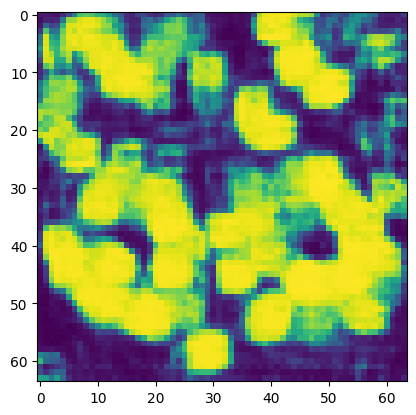

Epoch 21/100
25/25 [==============================] - ETA: 0s - loss: 0.3208 - mean_io_u_2: 0.2436
Epoch 21: val_loss improved from 0.29674 to 0.28580, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 7s 300ms/step - loss: 0.3208 - mean_io_u_2: 0.2436 - val_loss: 0.2858 - val_mean_io_u_2: 0.2227


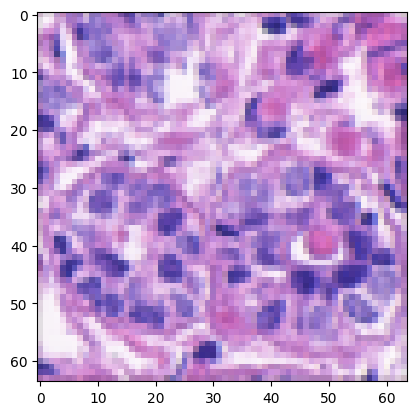

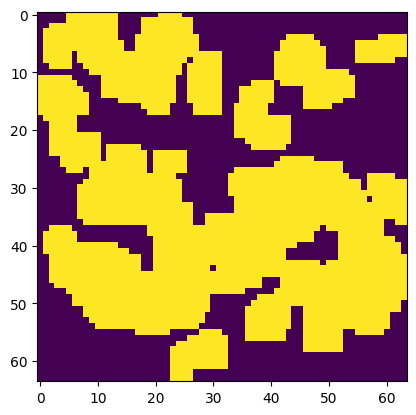

1/1 [==============================] - 0s 26ms/step


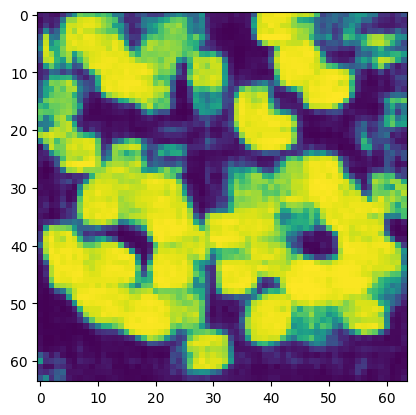

Epoch 22/100
25/25 [==============================] - ETA: 0s - loss: 0.2989 - mean_io_u_2: 0.2436
Epoch 22: val_loss improved from 0.28580 to 0.28433, saving model to model-BCC-UNET-v1.0.h5.checkpoint
25/25 [==============================] - 6s 244ms/step - loss: 0.2989 - mean_io_u_2: 0.2436 - val_loss: 0.2843 - val_mean_io_u_2: 0.2227


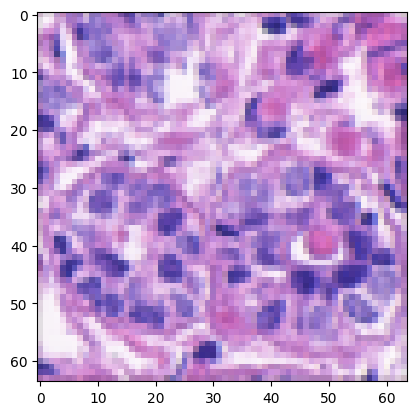

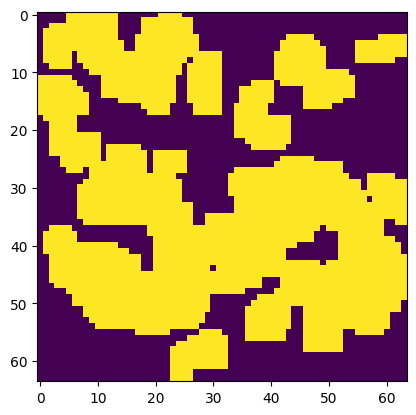

1/1 [==============================] - 0s 20ms/step


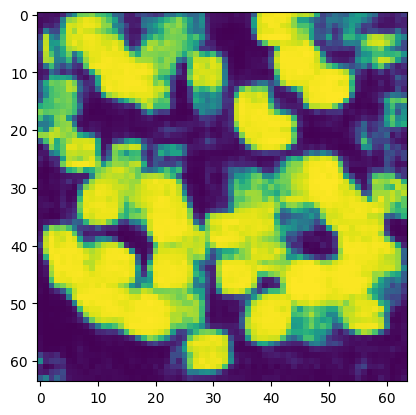

Epoch 23/100
24/25 [===========================>..] - ETA: 0s - loss: 0.3172 - mean_io_u_2: 0.2447
Epoch 23: val_loss did not improve from 0.28433
25/25 [==============================] - 1s 43ms/step - loss: 0.3172 - mean_io_u_2: 0.2436 - val_loss: 0.3031 - val_mean_io_u_2: 0.2227


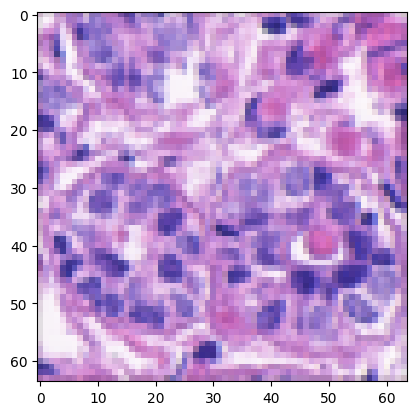

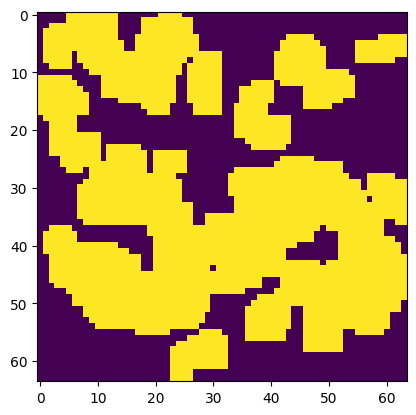

1/1 [==============================] - 0s 31ms/step


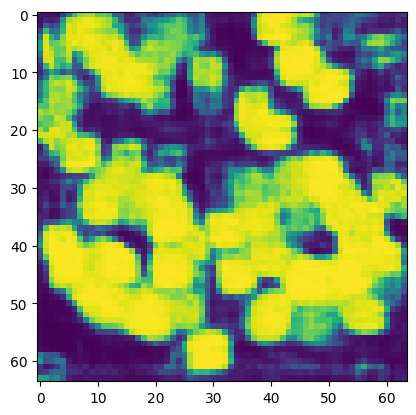

Epoch 24/100
25/25 [==============================] - ETA: 0s - loss: 0.3221 - mean_io_u_2: 0.2436
Epoch 24: val_loss did not improve from 0.28433
25/25 [==============================] - 1s 45ms/step - loss: 0.3221 - mean_io_u_2: 0.2436 - val_loss: 0.2954 - val_mean_io_u_2: 0.2227


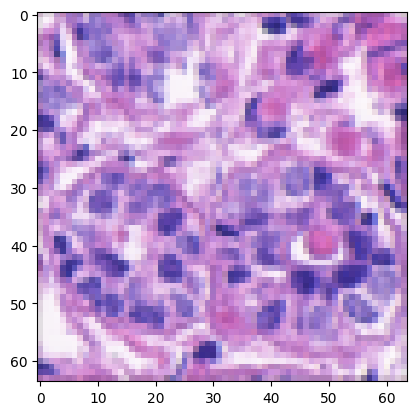

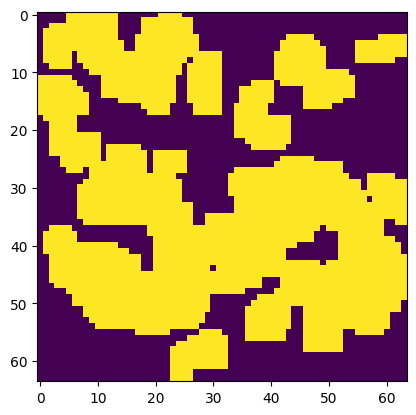

1/1 [==============================] - 0s 36ms/step


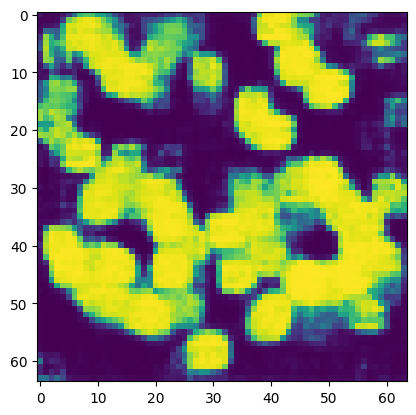

Epoch 25/100
25/25 [==============================] - ETA: 0s - loss: 0.3085 - mean_io_u_2: 0.2436
Epoch 25: val_loss did not improve from 0.28433
25/25 [==============================] - 1s 44ms/step - loss: 0.3085 - mean_io_u_2: 0.2436 - val_loss: 0.4255 - val_mean_io_u_2: 0.2227


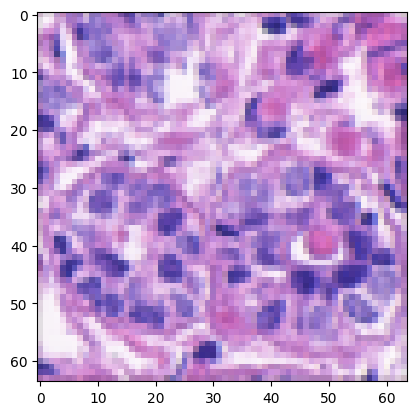

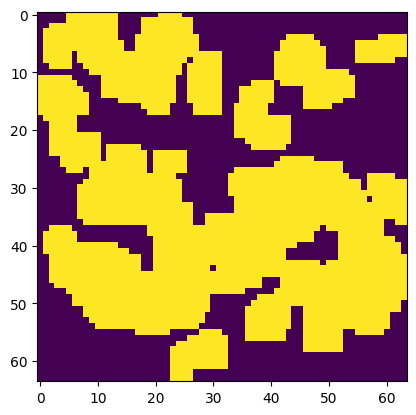

1/1 [==============================] - 0s 37ms/step


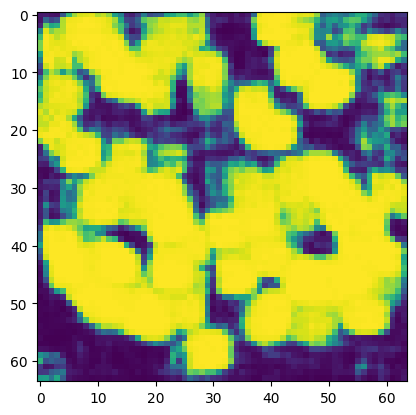

Epoch 26/100
25/25 [==============================] - ETA: 0s - loss: 0.3634 - mean_io_u_2: 0.2436
Epoch 26: val_loss did not improve from 0.28433
25/25 [==============================] - 1s 46ms/step - loss: 0.3634 - mean_io_u_2: 0.2436 - val_loss: 0.3066 - val_mean_io_u_2: 0.2227


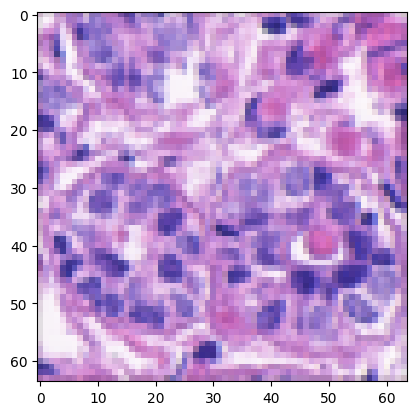

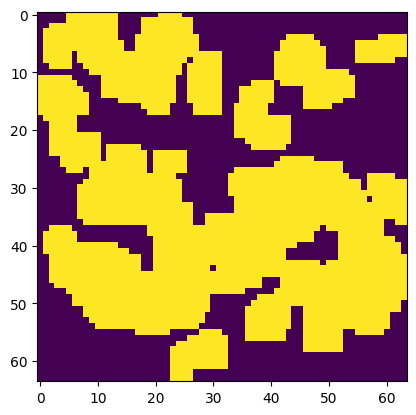

1/1 [==============================] - 0s 21ms/step


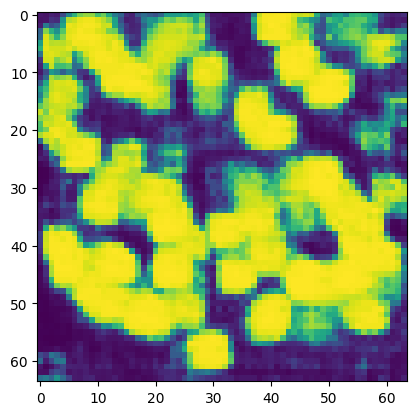

Epoch 27/100
25/25 [==============================] - ETA: 0s - loss: 0.2995 - mean_io_u_2: 0.2436
Epoch 27: val_loss did not improve from 0.28433
25/25 [==============================] - 1s 42ms/step - loss: 0.2995 - mean_io_u_2: 0.2436 - val_loss: 0.2959 - val_mean_io_u_2: 0.2227


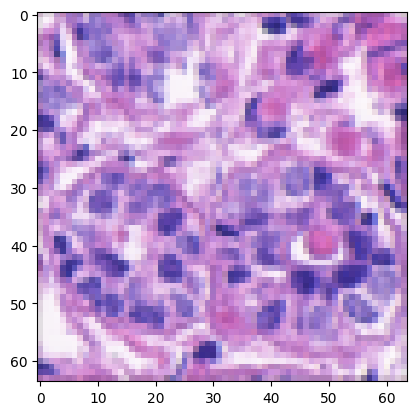

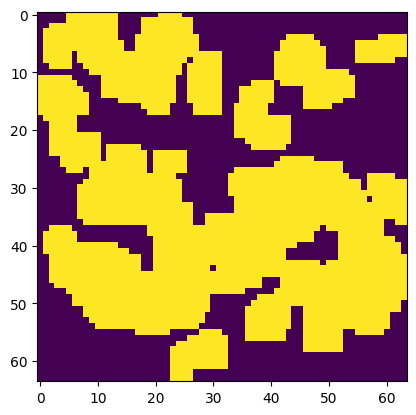

1/1 [==============================] - 0s 27ms/step


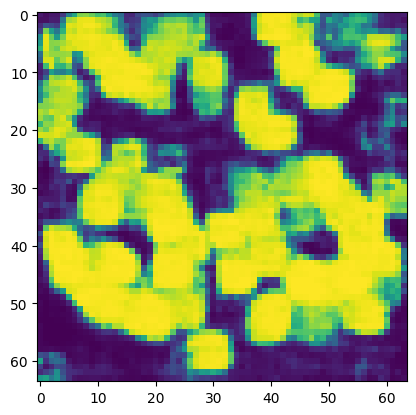

Epoch 28/100
25/25 [==============================] - ETA: 0s - loss: 0.2813 - mean_io_u_2: 0.2436
Epoch 28: val_loss did not improve from 0.28433
25/25 [==============================] - 1s 42ms/step - loss: 0.2813 - mean_io_u_2: 0.2436 - val_loss: 0.2906 - val_mean_io_u_2: 0.2227


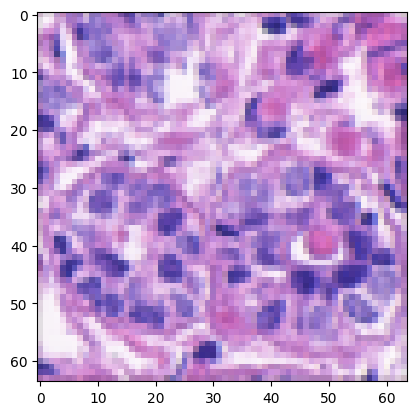

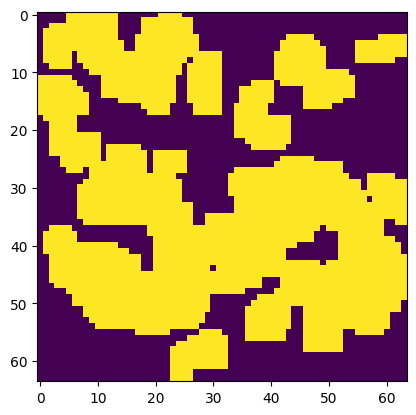

1/1 [==============================] - 0s 20ms/step


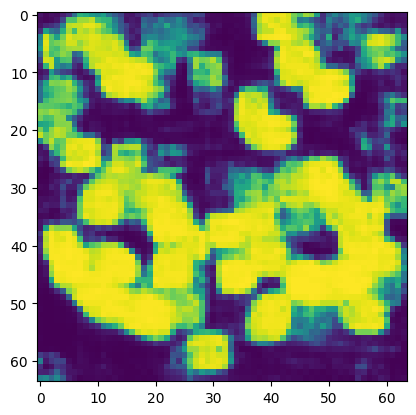

Epoch 29/100
25/25 [==============================] - ETA: 0s - loss: 0.2697 - mean_io_u_2: 0.2436
Epoch 29: val_loss did not improve from 0.28433
25/25 [==============================] - 1s 44ms/step - loss: 0.2697 - mean_io_u_2: 0.2436 - val_loss: 0.2907 - val_mean_io_u_2: 0.2227
Epoch 29: early stopping


In [ ]:
# آموزش و ارزیابی مدل

results = model.fit(Train_Inputs, Train_Masks,
                    validation_split=0.1,
                    batch_size=2,
                    epochs=100,
                    callbacks=[earlystopper, loss_history()])

In [ ]:
#  ارزیابی جهت نمایش نهایی

preds_train = model.predict(Train_Inputs, verbose=1)
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_test = model.predict(Test_Inputs, verbose=1)
preds_test_t = (preds_test>0.5).astype(np.uint8)



1/1 [==============================] - 0s 25ms/step


25
Train_Image


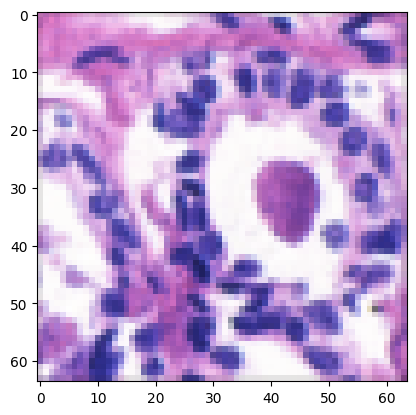

Train_Mask


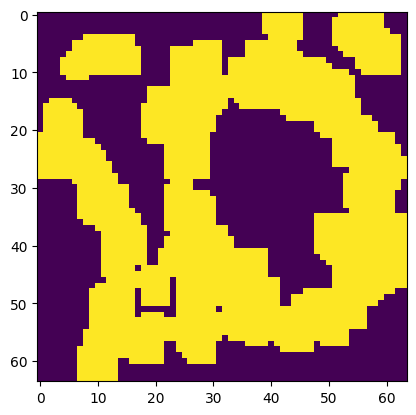

Segmented_Image


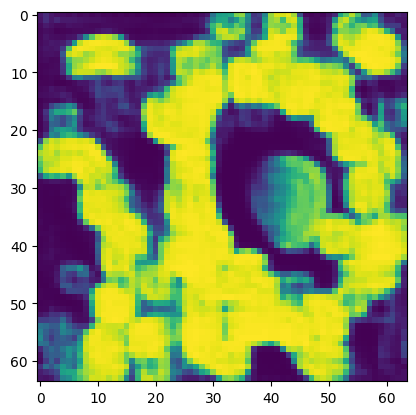

0
Test_Image


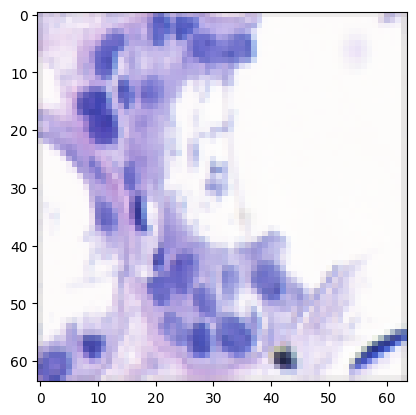

Test_Mask


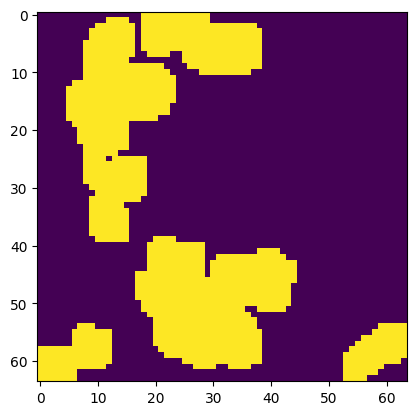

Segmented_Test_Mask


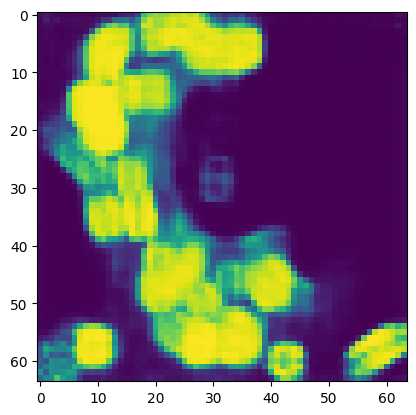

In [ ]:
# نمایش نتایج نهایی

ix = random.randint(0, len(Train_Inputs)-1)

print(ix)

print('Train_Image')
plt.imshow(Train_Inputs[ix])
plt.show()

print('Train_Mask')
plt.imshow(np.squeeze(Train_Masks[ix]))
plt.show()

print('Segmented_Image')
plt.imshow(np.squeeze(preds_train[ix]))
plt.show()


iix = random.randint(0,1)
print(iix)

print('Test_Image')
plt.imshow(Test_Inputs[iix])
plt.show()

print('Test_Mask')
plt.imshow(np.squeeze(Test_Masks[iix]))
plt.show()

print('Segmented_Test_Mask')
plt.imshow(np.squeeze(preds_test[iix]))
plt.show()



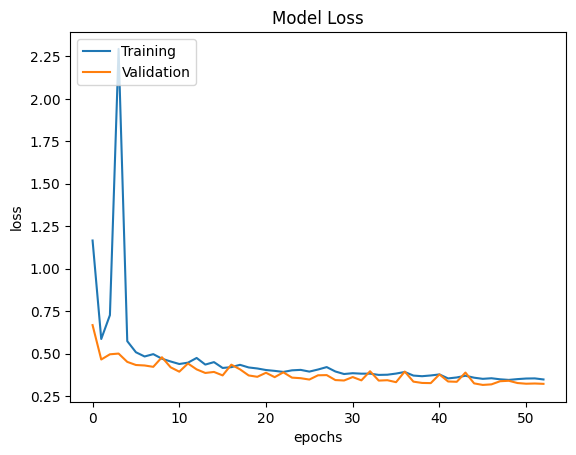

In [ ]:
# 11. Show Loss and IOU Plots
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Training','Validation'], loc = 'upper left')
plt.show()
